In [46]:
import copy
import time
import dgl
from utils import load_mat, preprocess_features, normalize_adj
from sklearn.metrics import roc_auc_score
import random
import os
import argparse
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.io as sio
import datetime
from gcn import GCN

from tqdm import tqdm
import matplotlib.pyplot as plt
from modules.model import Model, ModelGCN

In [47]:
class Args:
    def __init__(self):
        self.cuda = True
        
        self.dataset = "cora"
        self.device = "cuda:0"
        
        self.n_ggd_epochs = 300
        self.patience = 500
        self.batch_size = 300
        self.eval_freq = 1
        
        self.n_hidden = 256
        self.gnn_encoder = 'gcn'
        self.ggd_lr = 1e-3
        self.weight_decay = 0.
        
        self.subgraph_size = 1
args =  Args()
 


In [48]:
print('Dataset: {}'.format(args.dataset), flush=True)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = args.batch_size

adj, features, labels, idx_train, idx_val, idx_test, ano_label, str_ano_label, attr_ano_label = load_mat(args.dataset)

features, _ = preprocess_features(features)
src, dst = np.nonzero(adj)
g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)

# adj = normalize_adj(adj)
adj = (adj + sp.eye(adj.shape[0])).todense()
adj = torch.FloatTensor(adj[np.newaxis]).to(device)

Dataset: cora


In [49]:
nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[1]

features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)

Create GGD model

In [50]:

g = g.to(device)
# Create GGD model

gamma = 0.1
# for gamma in [0, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4]:
model = Model(
    g,
    ft_size,
    args.n_hidden,
    nn.PReLU(args.n_hidden),
    args.gnn_encoder,
    args.subgraph_size
)
# model = ModelGCN(
#     g, adj,
#     ft_size,
#     args.n_hidden,
#     nn.PReLU(args.n_hidden),
#     args.gnn_encoder,
#     args.subgraph_size
# )
if args.cuda:
    model.cuda()

In [51]:

optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.ggd_lr,
                                 weight_decay=args.weight_decay)
b_xent = nn.BCEWithLogitsLoss()

# train GGD

In [52]:
cnt_wait = 0
best = 1e9
best_t = 0
dur = [] # training time
loss_list = [] # loss

tag = str(datetime.datetime.now().strftime("%m-%d %H%M%S"))
# print("Memory beg:", torch.cuda.memory_allocated(device) / 1024 / 1024)

epoch_list = []
auc_score_list = []
auc_pos_list = []
auc_neg_list = []
pos_std = []
neg_std = []
score_std = []
label_positive = torch.zeros(1, g.number_of_nodes()).cuda()
label_negative = torch.ones(1, g.number_of_nodes()).cuda()
with tqdm(total=args.n_ggd_epochs) as pbar:
    pbar.set_description('Training')
    for epoch in range(args.n_ggd_epochs):
        
        if epoch % args.eval_freq == 0:
            model.eval()
            with torch.no_grad():
                epoch_list.append(epoch)
                s_positive = model(features)[0]
                pos_prob = s_positive.detach()[0].cpu().numpy()
                auc_pos_list.append(roc_auc_score(ano_label, pos_prob))
        
        model.train()
        t0 = time.time()
        optimizer.zero_grad()
        
        s_positive, s_negative, ggd_score_pos, ggd_score_neg, perm = model(features)
        
        loss_anomaly = b_xent(s_positive, label_positive) + b_xent(s_negative, label_negative)
        loss_ggd = b_xent(ggd_score_pos, label_positive) + b_xent(ggd_score_neg, label_negative)
        loss = (1-gamma) * loss_anomaly + gamma * loss_ggd
        loss.backward()
        
        optimizer.step()
        comp_time = time.time() - t0
        dur.append(comp_time)
        loss_list.append((loss.detach().cpu().item(), loss_anomaly.detach().cpu().item(), loss_ggd.detach().cpu().item()))

        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            # torch.save(ggd.state_dict(), 'checkpoints_ggd/best_ggd' + tag + '.pkl')
        else:
            cnt_wait += 1
    
        if cnt_wait == args.patience:
            print('Early stopping!')
            break
    
        
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 31.95it/s, loss=0.661]


# Visualization

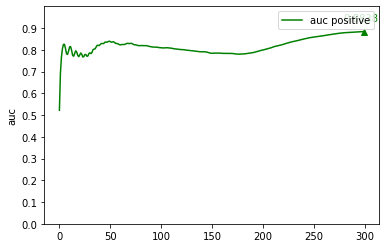

In [53]:
def draw_line(plt, epoch_list, data_list, color, label, max_marker=None):
    plt.plot(epoch_list, data_list, color=color, label=label)
    if max_marker is not None:
        max_index = np.argmax(data_list)
        val_str = "{:.4f}".format(data_list[max_index])
        plt.plot(epoch_list[max_index],data_list[max_index], color=color, marker=max_marker)
        plt.annotate(val_str,xytext=(-20, 10), textcoords='offset points',
            xy=(epoch_list[max_index],data_list[max_index]), color=color)

draw_line(plt, epoch_list, auc_pos_list, 'g', label="auc positive", max_marker="^")

plt.ylabel('auc')
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, step=0.1))
plt.savefig("aggdv2.png", dpi=400)

In [54]:
print(f"largest auc ({np.argmax(np.array(auc_pos_list))}): {max(auc_pos_list)}", )
index_min_loss = np.argmin(np.array(loss_list)[:, 0])
print(f"smallest loss model ({index_min_loss}): {auc_pos_list[index_min_loss]}")

largest auc (299): 0.8837763878029712
smallest loss model (294): 0.8832655720615064
